In [53]:
import cv2
import numpy as np
import os

def detect_abandoned_objects(video_path, first_frame_path, output_dir, time_threshold_seconds=20, movement_threshold=20):
    # Creating output directory 
    os.makedirs(output_dir, exist_ok=True)

    # Read the first frame from the specified path
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        print("Failed to read the first frame")
        return

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Failed to open the video")
        return

    objects = {}
    saved_objects = set()  # Setting to track saved objects
    frame_count = 0
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Getting frames per second from the video
    time_threshold_frames = time_threshold_seconds * fps  # Converting seconds to frames
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_count += 1
        
        # Detecting new objects
        diff = cv2.absdiff(first_frame, frame)
        gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 0)
        _, thresh = cv2.threshold(blur, 20, 255, cv2.THRESH_BINARY)
        dilated = cv2.dilate(thresh, None, iterations=3)
        contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        # Updating existing objects and detecting new ones
        current_objects = {}
        for contour in contours:
            if cv2.contourArea(contour) > 1000:  # Filtering small contours
                (x, y, w, h) = cv2.boundingRect(contour)
                center = (x + w // 2, y + h // 2)
                
                matched = False
                for obj_id, obj_info in objects.items():
                    dist = np.sqrt((center[0] - obj_info['center'][0])**2 + (center[1] - obj_info['center'][1])**2)
                    if dist < movement_threshold:
                        current_objects[obj_id] = {
                            'center': center,
                            'start_frame': obj_info['start_frame'],
                            'bbox': (x, y, w, h)
                        }
                        matched = True
                        break
                
                if not matched:
                    new_id = len(objects) + len(current_objects)
                    current_objects[new_id] = {
                        'center': center,
                        'start_frame': frame_count,
                        'bbox': (x, y, w, h)
                    }
        
        objects = current_objects
        
        # Check for abandoned objects
        abandoned_objects = []
        for obj_id, obj_info in objects.items():
            # Only considering objects that haven't moved significantly and have been in place for longer than the threshold
            if (frame_count - obj_info['start_frame']) > time_threshold_frames and obj_id not in saved_objects:
                abandoned_objects.append(obj_info['bbox'])
                saved_objects.add(obj_id)  # Add object ID to saved set to avoid duplicates
        
        # Drawing bounding boxes for abandoned objects and save the frame
        if abandoned_objects:
            for (x, y, w, h) in abandoned_objects:
                cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
                cv2.putText(frame, 'Abandoned Object', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)
            
            output_path = os.path.join(output_dir, f'abandoned_object_frame_{frame_count}.jpg')
            cv2.imwrite(output_path, frame)
            print(f"Saved frame with abandoned object: {output_path}")
        
    
    cap.release()
    print("Finished processing video")

# Usage with the specified paths
video_path = './vidcv.mp4'
first_frame_path = './FrameNo0.png'
output_dir = './abandoned_objects_output'
detect_abandoned_objects(video_path, first_frame_path, output_dir, time_threshold_seconds=20)


Saved frame with abandoned object: ./abandoned_objects_output\abandoned_object_frame_2008.jpg
Finished processing video


Successfully read image: ./abandoned_objects_output\abandoned_object_frame_2008.jpg


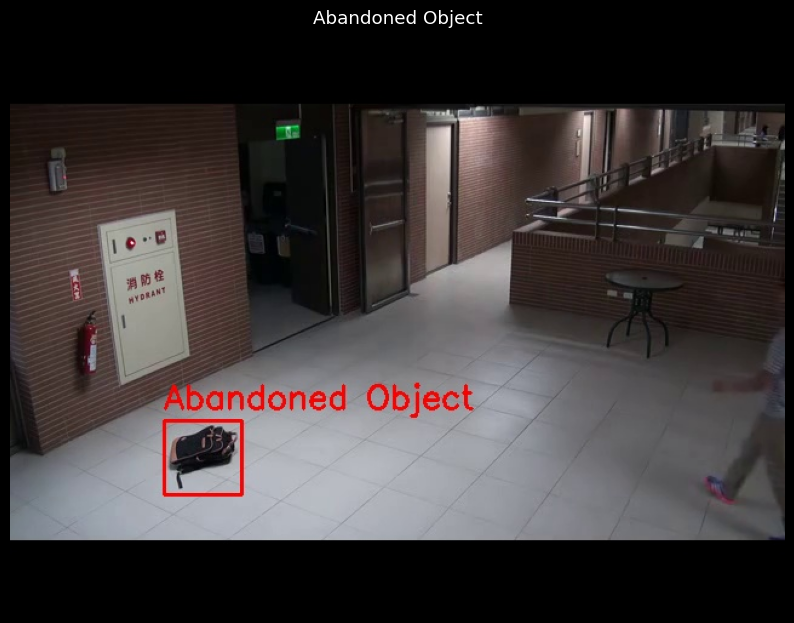

In [56]:
import cv2
import matplotlib.pyplot as plt
import os

%matplotlib inline

output_dir = './abandoned_objects_output'

# Listing all image files in the directory
saved_images = [os.path.join(output_dir, file) for file in os.listdir(output_dir) if file.endswith('.jpg')]

# Checking if images exist and print their status
if saved_images:
    
    # Read the first image
    img_path = saved_images[0]
    img = cv2.imread(img_path)
    
    if img is not None:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

        # Creating a figure and a single subplot
        fig, ax = plt.subplots(figsize=(10, 10))

        # Plotting the image
        ax.imshow(img_rgb)
        ax.set_title(f"Abandoned Object")
        ax.axis('off')  # Turn off axis labels
        
        # Displaying the image
        plt.show()
    else:
        print(f"Failed to read the image: {img_path}")
else:
    print(f"No images found in '{output_dir}'.")
